# SAGAN

Below implementation uses SAGAN with spectral norm and ttuf.

In [3]:
pip install numpy torch torchvision pillow tqdm tensorboard pytorch_image_generation_metrics

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def load_data(im_size, batch_size, workers, dataset, data_path):
    transform = transforms.Compose([
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    if dataset == 'cifar10':
        dataset = datasets.CIFAR10(data_path, train=True, transform=transform, download=True)
    else:
        assert False, f"Unknwn dataset: {dataset}"
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=workers,
                            drop_last=True,
                            pin_memory=True)
    return dataloader

In [5]:
from tqdm import trange
def generate_imgs(net_G, device, z_dim=128, size=5000, batch_size=128):
    net_G.eval()
    imgs = []
    with torch.no_grad():
        for start in trange(0, size, batch_size,
                            desc='Evaluating', ncols=0, leave=False):
            end = min(start + batch_size, size)
            z = torch.randn(end - start, z_dim).to(device)
            imgs.append(net_G(z).cpu())
    net_G.train()
    imgs = torch.cat(imgs, dim=0)
    imgs = (imgs + 1) / 2
    return imgs

In [6]:
import torch
import numpy as np
import torch.nn as nn


class Self_Attn(nn.Module):
    ''' Self attention Layer '''
    def __init__(self, in_channels, activation):
        super(Self_Attn, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        '''
            inputs:
                x: input feature maps (B x C x W x H)
            returns:
                out: self attention value + input feature
                attention: B x N x N (N is width * height)
        '''
        B, C, W, H = x.size()
        proj_query = self.query_conv(x).view(B, -1, W * H).permute(0, 2, 1) # B x N x C
        proj_key = self.key_conv(x).view(B, -1, W * H) # B X C x N
        energy = torch.bmm(proj_query, proj_key) # transpose check
        attention = self.softmax(energy) # B x N x N
        proj_value = self.value_conv(x).view(B, -1, W * H) # B x C x N
        out = torch.bmm(proj_value, attention.permute(0, 2, 1)) # B x C x N
        out = out.view(B, C, W, H)
        out = self.gamma * out + x
        return out, attention


class Generator(nn.Module):
    ''' Generator '''
    def __init__(self, batch_size, im_size=64, z_dim=100, conv_dim=64, adv_loss='hinge'):
        super(Generator, self).__init__()
        self.im_size = im_size
        Normalization = SpectralNorm if adv_loss == 'hinge' else lambda x: x
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.im_size)) - 2
        mult = 2 ** repeat_num # 8
        layer1.append(Normalization(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult # 512
        layer2.append(Normalization(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2) # 256
        layer3.append(Normalization(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        if self.im_size == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(Normalization(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)

        curr_dim = int(curr_dim / 2) # 128
        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(128, 'relu')
        self.attn2 = Self_Attn(64, 'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out = self.l1(z)
        out = self.l2(out)
        out = self.l3(out)
        out, p1 = self.attn1(out)
        if self.im_size == 64:
            out = self.l4(out)
            out, p2 = self.attn2(out)
        out = self.last(out)
        return out


class Discriminator(nn.Module):
    ''' Discriminator '''

    def __init__(self, batch_size=64, im_size=64, conv_dim=64, adv_loss='hinge'):
        super(Discriminator, self).__init__()
        self.im_size = im_size
        Normalization = SpectralNorm if adv_loss == 'hinge' else lambda x: x
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(Normalization(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))
        curr_dim = conv_dim

        layer2.append(Normalization(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(Normalization(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        if self.im_size == 64:
            layer4 = []
            layer4.append(Normalization(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim * 2

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(256, 'relu')
        self.attn2 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out, p1 = self.attn1(out)
        if self.im_size == 64:
            out = self.l4(out)
            out, p2 = self.attn2(out)
        out = self.last(out)
        return out.squeeze()

In [7]:
import torch
import torch.nn as nn


class SAGAN_Trainer:

    def __init__(self, args):
        self.args = args
        self._build_model()

    def _build_model(self):
        self.G = Generator(self.args.batch_size, self.args.im_size, self.args.z_dim, self.args.g_conv_dim, self.args.adv_loss)
        self.D = Discriminator(self.args.batch_size, self.args.im_size, self.args.d_conv_dim, self.args.adv_loss)
        self.G.to(self.args.device)
        self.D.to(self.args.device)
        if self.args.parallel:
            self.G = nn.DataParallel(self.G)
            self.D = nn.DataParallel(self.D)
        _G_params = filter(lambda p: p.requires_grad, self.G.parameters())
        _D_params = filter(lambda p: p.requires_grad, self.D.parameters())
        self.g_optimizer = torch.optim.Adam(_G_params, self.args.g_lr, [self.args.beta1, self.args.beta2])
        self.d_optimizer = torch.optim.Adam(_D_params, self.args.d_lr, [self.args.beta1, self.args.beta2])
        self.c_loss = nn.CrossEntropyLoss()

    def train(self, real_images):
        ''' train discriminator '''
        d_out_real = self.D(real_images)
        ''' compute loss with real images '''
        if self.args.adv_loss == 'wgan-gp':
            d_loss_real = -1 * torch.mean(d_out_real)
        elif self.args.adv_loss == 'hinge':
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
        ''' apply Gumbel Softmax '''
        z = torch.randn(real_images.size(0), self.args.z_dim).to(self.args.device)
        fake_images = self.G(z)
        d_out_fake = self.D(fake_images)
        ''' compute loss with fake images '''
        if self.args.adv_loss == 'wgan-gp':
            d_loss_fake = d_out_fake.mean()
        elif self.args.adv_loss == 'hinge':
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
        ''' update discriminator '''
        d_loss = d_loss_real + d_loss_fake
        self.d_optimizer.zero_grad()
        d_loss.backward()
        self.d_optimizer.step()
        if self.args.adv_loss == 'wgan-gp':
            ''' compute gradient penalty '''
            alpha = torch.rand(real_images.size(0), 1, 1, 1).to(self.args.device)
            interpolated = alpha * real_images.data + (1 - alpha) * fake_images.data
            interpolated.requires_grad_(True)
            d_out_itp = self.D(interpolated)
            grad = torch.autograd.grad(outputs=d_out_itp,
                                       inputs=interpolated,
                                       grad_outputs=torch.ones(d_out_itp.size()).to(self.args.device),
                                       retain_graph=True,
                                       create_graph=True,
                                       only_inputs=True)[0]
            grad_norm = grad.view(grad.size(0), -1).norm(dim=1)
            d_loss_gp = torch.mean((grad_norm - 1) ** 2)
            ''' optimize gradient penalty '''
            d_loss = self.args.lambda_gp * d_loss_gp
            self.d_optimizer.zero_grad()
            d_loss.backward()
            self.d_optimizer.step()
        ''' train generator '''
        z = torch.randn(real_images.size(0), self.args.z_dim).to(self.args.device)
        fake_images = self.G(z)
        g_out_fake = self.D(fake_images)
        ''' compute loss with fake images '''
        g_loss_fake = -1 * g_out_fake.mean()
        self.g_optimizer.zero_grad()
        g_loss_fake.backward()
        self.g_optimizer.step()
        return d_loss_real.item(), d_loss_fake.item(), g_loss_fake.item()

In [8]:
import torch
from torch import nn
from torchvision.models.inception import inception_v3


class Scorer:

    def __init__(self, device, resize=True):
        self.resize = resize
        self.inception_model = inception_v3(pretrained=True, transform_input=False)
        self.inception_model.to(device)
        self.inception_model.eval()
        if self.resize:
            self.upsample = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True)
        self.softmax = nn.Softmax(dim=-1)

    @torch.no_grad()
    def get_preds(self, samples):
        mean = samples.new_tensor((0.485, 0.456, 0.406)).view(1, -1, 1, 1)
        std = samples.new_tensor((0.229, 0.224, 0.225)).view(1, -1, 1, 1)
        samples = (samples - mean) / std
        samples = self.upsample(samples) if self.resize else samples
        return self.softmax(self.inception_model(samples)).detach()

    @torch.no_grad()
    def compute_score(self, preds, splits=10):
        scores = list()
        total_num = preds.size(0)
        for k in range(splits):
            part = preds[k * (total_num//splits): (k+1) * (total_num//splits), :]
            kl = part * (part.log() - part.mean(dim=0, keepdim=True).log())
            scores.append(kl.sum(dim=1).mean().exp())
        scores = torch.stack(scores, dim=0)
        inception_score = torch.mean(scores).item()
        std = torch.std(scores).item()
        return inception_score, std

In [9]:
import torch
import torch.nn as nn


class SpectralNorm(nn.Module):

    def __init__(self, module, name='weight'):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        if not hasattr(self.module, self.name + '_bar'):
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + '_u')
        v = getattr(self.module, self.name + '_v')
        w = getattr(self.module, self.name + '_bar')
        height = w.size(0)
        with torch.no_grad():
            v = self._l2normalize(w.view(height, -1).transpose(0, 1).mv(u))
            u = self._l2normalize(w.view(height, -1).mv(v))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _make_params(self):
        w = getattr(self.module, self.name)
        height = w.size(0)
        width = w.view(height, -1).size(1)
        u = nn.Parameter(self._l2normalize(w.new_empty(height).normal_(0, 1)), requires_grad=False)
        v = nn.Parameter(self._l2normalize(w.new_empty(width).normal_(0, 1)), requires_grad=False)
        w_bar = nn.Parameter(w.data)
        del self.module._parameters[self.name]
        self.module.register_parameter(self.name + '_u', u)
        self.module.register_parameter(self.name + '_v', v)
        self.module.register_parameter(self.name + '_bar', w_bar)

    def forward(self, *args, **kwargs):
        self._update_u_v()
        return self.module.forward(*args, **kwargs)

    @staticmethod
    def _l2normalize(v, eps=1e-12):
        return v / (v.norm() + eps)

In [10]:
import os
import time
import torch
import random
from tqdm import tqdm
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from pytorch_image_generation_metrics import get_inception_score_and_fid

class Instructor:

    def __init__(self, dataset='cifar10', data_dir='data', sample_dir='sample', save_dir='saves', num_workers=16,
                 im_size=32, z_dim=128, g_conv_dim=64, d_conv_dim=64, total_step=20000, batch_size=64, g_lr=0.0001,
                 d_lr=0.0004, beta1=0.0, beta2=0.9, lambda_gp=10, adv_loss='hinge', device=None, parallel=False,
                 log_step=20, sample_step=200, eval_step=500, model_save_step=10, sample_num=100, timestamp=None, num_images = 50000):

        # Assign all argument values to class variables
        self.dataset = dataset
        self.data_dir = data_dir
        self.sample_dir = sample_dir
        self.save_dir = save_dir
        self.num_workers = num_workers
        self.im_size = im_size
        self.z_dim = z_dim
        self.g_conv_dim = g_conv_dim
        self.d_conv_dim = d_conv_dim
        self.total_step = total_step
        self.batch_size = batch_size
        # ttuf
        self.g_lr = g_lr
        self.d_lr = d_lr


        self.beta1 = beta1
        self.beta2 = beta2
        self.lambda_gp = lambda_gp
        self.adv_loss = adv_loss
        self.device = torch.device(device if device else 'cuda' if torch.cuda.is_available() else 'cpu')
        self.parallel = parallel
        self.log_step = log_step
        self.sample_step = sample_step
        self.eval_step = eval_step
        self.model_save_step = model_save_step
        self.sample_num = sample_num
        self.timestamp = timestamp if timestamp else str(int(time.time())) + format(random.randint(0, 999), '03')
        self.num_images = num_images
        self.fid_cache = './stats/cifar10.train.npz'  # FID cache
        self.fid_scores = []
        self.inception_scores = []
        # Create directories
        # Ensure directories exist
        for dir_name in [self.data_dir, self.sample_dir, self.save_dir]:
            if not os.path.exists(dir_name):
                os.mkdir(dir_name)
        os.mkdir(os.path.join(self.sample_dir, self.timestamp))
        os.mkdir(os.path.join(self.save_dir, self.timestamp))

        # Set environment settings
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        torch.backends.cudnn.benchmark = True

        self._print_args()

    def _print_args(self):
        print('TRAINING ARGUMENTS:')
        for key, value in vars(self).items():
            print(f">>> {key}: {value}")
    def get_FID(self):
      return self.fid_scores;
    def get_IS(self):
      return self.inception_scores;

    def train_sagan(self):
        print('=> creating model...')
        trainer = SAGAN_Trainer(self)
        writer = SummaryWriter()
        print('=> creating scorer...')
        scorer = Scorer(device=self.device, resize=True)
        print('=> loading data...')
        dataloader = load_data(im_size=self.im_size,
                               batch_size=self.batch_size,
                               workers=self.num_workers,
                               dataset=self.dataset,
                               data_path=os.path.join(self.data_dir, self.dataset))
        data_iter = iter(dataloader)
        model_save_step = int(self.model_save_step * len(dataloader))
        fixed_z = torch.randn(self.batch_size, self.z_dim).to(self.device)
        real_images, _ = next(data_iter)
        real_images = (real_images * 0.5 + 0.5).clamp(0, 1)
        writer.add_images('real', real_images, 0)
        save_image(real_images, os.path.join(self.sample_dir, self.timestamp, 'real.png'))
        all_preds = list()
        for inputs, _ in tqdm(dataloader):
            inputs = inputs.to(self.device) * 0.5 + 0.5
            all_preds.append(scorer.get_preds(inputs))
        score, _ = scorer.compute_score(torch.cat(all_preds, dim=0), splits=10)
        print(f"real inception score: {score:.4f}")
        best_score = 0

        for step in range(self.total_step):
            ''' train sagan model '''
            trainer.D.train()
            trainer.G.train()
            try:
                real_images, _ = next(data_iter)
            except StopIteration:
                data_iter = iter(dataloader)
                real_images, _ = next(data_iter)
            real_images = real_images.to(self.device)
            d_loss_real, d_loss_fake, g_loss_fake = trainer.train(real_images)
            ''' print info '''
            if (step + 1) % self.log_step == 0:
                print(f"step: {step + 1}/{self.total_step}, g_loss_fake: {g_loss_fake:.4f}")
                writer.add_scalar('Loss/D_real', d_loss_real, step + 1)
                writer.add_scalar('Loss/D_fake', d_loss_fake, step + 1)
                writer.add_scalar('Loss/G_fake', g_loss_fake, step + 1)
                writer.add_scalar('Score/G_attn1', trainer.G.attn1.gamma.mean().item(), step + 1)
                writer.add_scalar('Score/D_attn1', trainer.D.attn1.gamma.mean().item(), step + 1)
            ''' compute inception score '''
            if (step + 1) % self.eval_step == 0:
                trainer.G.eval()
                all_preds = list()
                for _ in tqdm(range(self.sample_num)):
                    z = torch.randn(self.batch_size, self.z_dim).to(self.device)
                    inputs = trainer.G(z) * 0.5 + 0.5
                    all_preds.append(scorer.get_preds(inputs))
                score, _ = scorer.compute_score(torch.cat(all_preds, dim=0), splits=10)
                best_score = max(score, best_score)
                print(f"fake inception score: {score:.4f}")
                writer.add_scalar('Score/IS_fake', score, step + 1)
                imgs = generate_imgs(
                        trainer.G, self.device, self.z_dim,
                        self.num_images, self.batch_size)


                IS, FID = get_inception_score_and_fid(
                        imgs, self.fid_cache, verbose=True)
                self.fid_scores.append([step, FID])
                self.inception_scores.append([step, IS[0]])
                print(
                        "%s/%s Inception Score: %.3f(%.5f), "
                        "FID: %6.3f" % (
                            step, self.total_step, IS[0], IS[1], FID))
                writer.add_scalar('Inception_Score', IS[0], step)
                writer.add_scalar('Inception_Score_std', IS[1], step)
                writer.add_scalar('FID', FID, step)
            ''' sample image '''
            if (step + 1) % self.sample_step == 0:
                trainer.G.eval()
                fake_images = trainer.G(fixed_z)
                fake_images = (fake_images * 0.5 + 0.5).clamp(0, 1)
                writer.add_images('fake', fake_images, step + 1)
                save_image(fake_images, os.path.join(self.sample_dir, self.timestamp, f"fake_{step + 1}.png"))
            ''' save model '''
            if (step + 1) % model_save_step == 0:
                torch.save(trainer.G.state_dict(), os.path.join(self.save_dir, self.timestamp, f"{step + 1}_G.pt"))
                torch.save(trainer.D.state_dict(), os.path.join(self.save_dir, self.timestamp, f"{step + 1}_D.pt"))
        writer.close()
        print(f"best inception score: {best_score:.4f}")





In [11]:
ins = Instructor()
ins.train_sagan()
ins

TRAINING ARGUMENTS:
>>> dataset: cifar10
>>> data_dir: data
>>> sample_dir: sample
>>> save_dir: saves
>>> num_workers: 16
>>> im_size: 32
>>> z_dim: 128
>>> g_conv_dim: 64
>>> d_conv_dim: 64
>>> total_step: 20000
>>> batch_size: 64
>>> g_lr: 0.0001
>>> d_lr: 0.0004
>>> beta1: 0.0
>>> beta2: 0.9
>>> lambda_gp: 10
>>> adv_loss: hinge
>>> device: cuda
>>> parallel: False
>>> log_step: 20
>>> sample_step: 200
>>> eval_step: 500
>>> model_save_step: 10
>>> sample_num: 100
>>> timestamp: 1726334044403
>>> num_images: 50000
>>> fid_cache: ./stats/cifar10.train.npz
>>> fid_scores: []
>>> inception_scores: []
=> creating model...
=> creating scorer...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 210MB/s]


=> loading data...


100%|██████████| 170498071/170498071 [00:12<00:00, 13303553.93it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:24<00:00, 31.46it/s]


real inception score: 10.2104
step: 20/20000, g_loss_fake: 11.2208
step: 40/20000, g_loss_fake: 6.8975
step: 60/20000, g_loss_fake: 6.7693
step: 80/20000, g_loss_fake: 9.0487
step: 100/20000, g_loss_fake: 2.8612
step: 120/20000, g_loss_fake: 7.1209
step: 140/20000, g_loss_fake: 0.9019
step: 160/20000, g_loss_fake: 2.1068
step: 180/20000, g_loss_fake: 3.9245
step: 200/20000, g_loss_fake: 1.3735
step: 220/20000, g_loss_fake: 1.8972
step: 240/20000, g_loss_fake: 0.7997
step: 260/20000, g_loss_fake: 1.1673
step: 280/20000, g_loss_fake: 0.6843
step: 300/20000, g_loss_fake: 1.3885
step: 320/20000, g_loss_fake: 0.6367
step: 340/20000, g_loss_fake: 0.4772
step: 360/20000, g_loss_fake: -0.1863
step: 380/20000, g_loss_fake: 1.1674
step: 400/20000, g_loss_fake: 1.7480
step: 420/20000, g_loss_fake: 0.2883
step: 440/20000, g_loss_fake: 1.8671
step: 460/20000, g_loss_fake: 2.5481
step: 480/20000, g_loss_fake: 0.9883
step: 500/20000, g_loss_fake: 1.0729


100%|██████████| 100/100 [00:03<00:00, 32.05it/s]


fake inception score: 2.0499


Downloading: "https://github.com/w86763777/pytorch-image-generation-metrics/releases/download/v0.1.0/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:03<00:00, 26.0MB/s]


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

499/20000 Inception Score: 1.987(0.01346), FID: 281.679
step: 520/20000, g_loss_fake: 2.1312
step: 540/20000, g_loss_fake: 0.8624
step: 560/20000, g_loss_fake: 2.0208
step: 580/20000, g_loss_fake: 1.5434
step: 600/20000, g_loss_fake: 3.1988
step: 620/20000, g_loss_fake: 0.4147
step: 640/20000, g_loss_fake: 1.3243
step: 660/20000, g_loss_fake: 0.6533
step: 680/20000, g_loss_fake: 2.8777
step: 700/20000, g_loss_fake: 2.3661
step: 720/20000, g_loss_fake: 1.3340
step: 740/20000, g_loss_fake: 1.8616
step: 760/20000, g_loss_fake: 1.4597
step: 780/20000, g_loss_fake: 2.1051
step: 800/20000, g_loss_fake: 2.7298
step: 820/20000, g_loss_fake: 2.3344
step: 840/20000, g_loss_fake: 1.2667
step: 860/20000, g_loss_fake: 1.0808
step: 880/20000, g_loss_fake: 2.0824
step: 900/20000, g_loss_fake: 2.5210
step: 920/20000, g_loss_fake: 0.9100
step: 940/20000, g_loss_fake: 0.3708
step: 960/20000, g_loss_fake: 0.8366
step: 980/20000, g_loss_fake: 1.1904
step: 1000/20000, g_loss_fake: 1.9070


100%|██████████| 100/100 [00:03<00:00, 32.25it/s]


fake inception score: 1.8900


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

999/20000 Inception Score: 2.428(0.01812), FID: 247.436
step: 1020/20000, g_loss_fake: 2.5274
step: 1040/20000, g_loss_fake: 1.8667
step: 1060/20000, g_loss_fake: 1.4232
step: 1080/20000, g_loss_fake: 2.3166
step: 1100/20000, g_loss_fake: 1.5638
step: 1120/20000, g_loss_fake: 2.5156
step: 1140/20000, g_loss_fake: 3.0224
step: 1160/20000, g_loss_fake: 2.5914
step: 1180/20000, g_loss_fake: 0.0265
step: 1200/20000, g_loss_fake: 2.4378
step: 1220/20000, g_loss_fake: 1.0184
step: 1240/20000, g_loss_fake: 2.4783
step: 1260/20000, g_loss_fake: 1.1880
step: 1280/20000, g_loss_fake: 1.0617
step: 1300/20000, g_loss_fake: 2.1118
step: 1320/20000, g_loss_fake: 1.9403
step: 1340/20000, g_loss_fake: 0.2741
step: 1360/20000, g_loss_fake: 0.4985
step: 1380/20000, g_loss_fake: 1.2708
step: 1400/20000, g_loss_fake: 1.2858
step: 1420/20000, g_loss_fake: 3.0937
step: 1440/20000, g_loss_fake: 0.9462
step: 1460/20000, g_loss_fake: 1.6201
step: 1480/20000, g_loss_fake: 0.8978
step: 1500/20000, g_loss_fake: 2

100%|██████████| 100/100 [00:03<00:00, 32.30it/s]


fake inception score: 1.9500


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

1499/20000 Inception Score: 2.199(0.01400), FID: 229.690
step: 1520/20000, g_loss_fake: 1.8859
step: 1540/20000, g_loss_fake: 1.2190
step: 1560/20000, g_loss_fake: 0.4739
step: 1580/20000, g_loss_fake: -0.0771
step: 1600/20000, g_loss_fake: 1.0760
step: 1620/20000, g_loss_fake: 1.0529
step: 1640/20000, g_loss_fake: 0.6577
step: 1660/20000, g_loss_fake: 3.2158
step: 1680/20000, g_loss_fake: 0.9131
step: 1700/20000, g_loss_fake: 1.1992
step: 1720/20000, g_loss_fake: 0.9657
step: 1740/20000, g_loss_fake: -0.1526
step: 1760/20000, g_loss_fake: 3.0438
step: 1780/20000, g_loss_fake: 1.5296
step: 1800/20000, g_loss_fake: 1.3581
step: 1820/20000, g_loss_fake: 1.3947
step: 1840/20000, g_loss_fake: 1.3122
step: 1860/20000, g_loss_fake: 1.1585
step: 1880/20000, g_loss_fake: 2.0058
step: 1900/20000, g_loss_fake: 1.4715
step: 1920/20000, g_loss_fake: 2.7798
step: 1940/20000, g_loss_fake: 1.0922
step: 1960/20000, g_loss_fake: 0.8103
step: 1980/20000, g_loss_fake: 3.7533
step: 2000/20000, g_loss_fake

100%|██████████| 100/100 [00:03<00:00, 31.87it/s]


fake inception score: 2.2910


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

1999/20000 Inception Score: 2.743(0.01996), FID: 161.261
step: 2020/20000, g_loss_fake: 4.3858
step: 2040/20000, g_loss_fake: 2.1492
step: 2060/20000, g_loss_fake: 0.9841
step: 2080/20000, g_loss_fake: 2.5408
step: 2100/20000, g_loss_fake: 1.4620
step: 2120/20000, g_loss_fake: 1.4906
step: 2140/20000, g_loss_fake: 2.4760
step: 2160/20000, g_loss_fake: 2.2682
step: 2180/20000, g_loss_fake: 1.3452
step: 2200/20000, g_loss_fake: 2.2766
step: 2220/20000, g_loss_fake: 1.5377
step: 2240/20000, g_loss_fake: 1.8450
step: 2260/20000, g_loss_fake: 3.4981
step: 2280/20000, g_loss_fake: 3.6866
step: 2300/20000, g_loss_fake: 4.0769
step: 2320/20000, g_loss_fake: 1.9139
step: 2340/20000, g_loss_fake: 1.6310
step: 2360/20000, g_loss_fake: 3.5227
step: 2380/20000, g_loss_fake: 1.9338
step: 2400/20000, g_loss_fake: 2.8126
step: 2420/20000, g_loss_fake: 2.7109
step: 2440/20000, g_loss_fake: 2.6955
step: 2460/20000, g_loss_fake: 2.9500
step: 2480/20000, g_loss_fake: 6.8417
step: 2500/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.44it/s]


fake inception score: 2.4531


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

2499/20000 Inception Score: 2.981(0.02953), FID: 141.343
step: 2520/20000, g_loss_fake: 3.8521
step: 2540/20000, g_loss_fake: 1.9585
step: 2560/20000, g_loss_fake: 2.4076
step: 2580/20000, g_loss_fake: 2.7832
step: 2600/20000, g_loss_fake: 1.9098
step: 2620/20000, g_loss_fake: 2.1130
step: 2640/20000, g_loss_fake: 2.5900
step: 2660/20000, g_loss_fake: 4.4928
step: 2680/20000, g_loss_fake: 2.9312
step: 2700/20000, g_loss_fake: 2.1828
step: 2720/20000, g_loss_fake: 2.6050
step: 2740/20000, g_loss_fake: 3.3589
step: 2760/20000, g_loss_fake: 3.0911
step: 2780/20000, g_loss_fake: 2.5655
step: 2800/20000, g_loss_fake: 4.5260
step: 2820/20000, g_loss_fake: 2.2783
step: 2840/20000, g_loss_fake: 3.7431
step: 2860/20000, g_loss_fake: 4.2681
step: 2880/20000, g_loss_fake: 2.2529
step: 2900/20000, g_loss_fake: 2.7934
step: 2920/20000, g_loss_fake: 2.6278
step: 2940/20000, g_loss_fake: 2.7386
step: 2960/20000, g_loss_fake: 2.2498
step: 2980/20000, g_loss_fake: 4.5640
step: 3000/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 32.12it/s]


fake inception score: 2.6027


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

2999/20000 Inception Score: 3.070(0.03310), FID: 148.040
step: 3020/20000, g_loss_fake: 3.6934
step: 3040/20000, g_loss_fake: 7.3492
step: 3060/20000, g_loss_fake: 4.0290
step: 3080/20000, g_loss_fake: 2.4360
step: 3100/20000, g_loss_fake: 2.6859
step: 3120/20000, g_loss_fake: 5.2256
step: 3140/20000, g_loss_fake: 4.2432
step: 3160/20000, g_loss_fake: 3.6490
step: 3180/20000, g_loss_fake: 2.7309
step: 3200/20000, g_loss_fake: 2.3844
step: 3220/20000, g_loss_fake: 1.8211
step: 3240/20000, g_loss_fake: 2.6321
step: 3260/20000, g_loss_fake: 4.9005
step: 3280/20000, g_loss_fake: 3.6212
step: 3300/20000, g_loss_fake: 4.9163
step: 3320/20000, g_loss_fake: 4.8217
step: 3340/20000, g_loss_fake: 3.1209
step: 3360/20000, g_loss_fake: 4.3349
step: 3380/20000, g_loss_fake: 2.4109
step: 3400/20000, g_loss_fake: 3.7681
step: 3420/20000, g_loss_fake: 3.5820
step: 3440/20000, g_loss_fake: 5.1115
step: 3460/20000, g_loss_fake: 3.8325
step: 3480/20000, g_loss_fake: 2.1049
step: 3500/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.81it/s]


fake inception score: 2.7479


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

3499/20000 Inception Score: 3.320(0.04212), FID: 133.941
step: 3520/20000, g_loss_fake: 2.8830
step: 3540/20000, g_loss_fake: 5.1543
step: 3560/20000, g_loss_fake: 4.6792
step: 3580/20000, g_loss_fake: 2.7373
step: 3600/20000, g_loss_fake: 3.2690
step: 3620/20000, g_loss_fake: 3.9853
step: 3640/20000, g_loss_fake: 3.2605
step: 3660/20000, g_loss_fake: 6.0663
step: 3680/20000, g_loss_fake: 2.7858
step: 3700/20000, g_loss_fake: 4.9073
step: 3720/20000, g_loss_fake: 4.2270
step: 3740/20000, g_loss_fake: 2.6057
step: 3760/20000, g_loss_fake: 2.4054
step: 3780/20000, g_loss_fake: 2.5409
step: 3800/20000, g_loss_fake: 2.8188
step: 3820/20000, g_loss_fake: 2.3580
step: 3840/20000, g_loss_fake: 3.0666
step: 3860/20000, g_loss_fake: 2.6389
step: 3880/20000, g_loss_fake: 3.6700
step: 3900/20000, g_loss_fake: 2.2526
step: 3920/20000, g_loss_fake: 4.1367
step: 3940/20000, g_loss_fake: 3.3140
step: 3960/20000, g_loss_fake: 2.6064
step: 3980/20000, g_loss_fake: 4.0031
step: 4000/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.81it/s]


fake inception score: 2.6379


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

3999/20000 Inception Score: 3.211(0.04399), FID: 145.082
step: 4020/20000, g_loss_fake: 1.7491
step: 4040/20000, g_loss_fake: 3.7558
step: 4060/20000, g_loss_fake: 2.5103
step: 4080/20000, g_loss_fake: 4.2280
step: 4100/20000, g_loss_fake: 6.1672
step: 4120/20000, g_loss_fake: 3.5223
step: 4140/20000, g_loss_fake: 3.3785
step: 4160/20000, g_loss_fake: 2.4742
step: 4180/20000, g_loss_fake: 3.9480
step: 4200/20000, g_loss_fake: 4.7382
step: 4220/20000, g_loss_fake: 3.5631
step: 4240/20000, g_loss_fake: 5.6950
step: 4260/20000, g_loss_fake: 2.1132
step: 4280/20000, g_loss_fake: 3.6282
step: 4300/20000, g_loss_fake: 2.4007
step: 4320/20000, g_loss_fake: 2.7809
step: 4340/20000, g_loss_fake: 3.4819
step: 4360/20000, g_loss_fake: 3.9521
step: 4380/20000, g_loss_fake: 6.2777
step: 4400/20000, g_loss_fake: 2.8159
step: 4420/20000, g_loss_fake: 8.0289
step: 4440/20000, g_loss_fake: 4.0052
step: 4460/20000, g_loss_fake: 2.3365
step: 4480/20000, g_loss_fake: 4.2940
step: 4500/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.97it/s]


fake inception score: 2.5157


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

4499/20000 Inception Score: 3.043(0.04184), FID: 147.550
step: 4520/20000, g_loss_fake: 2.1889
step: 4540/20000, g_loss_fake: 4.5554
step: 4560/20000, g_loss_fake: 2.1219
step: 4580/20000, g_loss_fake: 2.9688
step: 4600/20000, g_loss_fake: 2.9438
step: 4620/20000, g_loss_fake: 2.5196
step: 4640/20000, g_loss_fake: 2.5243
step: 4660/20000, g_loss_fake: 2.2185
step: 4680/20000, g_loss_fake: 2.6789
step: 4700/20000, g_loss_fake: 4.5434
step: 4720/20000, g_loss_fake: 2.5158
step: 4740/20000, g_loss_fake: 3.1022
step: 4760/20000, g_loss_fake: 3.8311
step: 4780/20000, g_loss_fake: 2.8594
step: 4800/20000, g_loss_fake: 3.2287
step: 4820/20000, g_loss_fake: 2.6491
step: 4840/20000, g_loss_fake: 3.6351
step: 4860/20000, g_loss_fake: 2.6294
step: 4880/20000, g_loss_fake: 2.5358
step: 4900/20000, g_loss_fake: 3.6557
step: 4920/20000, g_loss_fake: 2.7772
step: 4940/20000, g_loss_fake: 4.0310
step: 4960/20000, g_loss_fake: 2.5427
step: 4980/20000, g_loss_fake: 2.1570
step: 5000/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.60it/s]


fake inception score: 2.5720


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

4999/20000 Inception Score: 3.167(0.02222), FID: 144.818
step: 5020/20000, g_loss_fake: 2.6225
step: 5040/20000, g_loss_fake: 1.8816
step: 5060/20000, g_loss_fake: 5.5322
step: 5080/20000, g_loss_fake: 3.7624
step: 5100/20000, g_loss_fake: 4.7071
step: 5120/20000, g_loss_fake: 2.4137
step: 5140/20000, g_loss_fake: 4.2555
step: 5160/20000, g_loss_fake: 3.4271
step: 5180/20000, g_loss_fake: 3.1325
step: 5200/20000, g_loss_fake: 2.1166
step: 5220/20000, g_loss_fake: 3.7202
step: 5240/20000, g_loss_fake: 2.8861
step: 5260/20000, g_loss_fake: 0.9547
step: 5280/20000, g_loss_fake: 3.6121
step: 5300/20000, g_loss_fake: 3.5639
step: 5320/20000, g_loss_fake: 5.6690
step: 5340/20000, g_loss_fake: 2.5229
step: 5360/20000, g_loss_fake: 3.1774
step: 5380/20000, g_loss_fake: 2.6134
step: 5400/20000, g_loss_fake: 1.7519
step: 5420/20000, g_loss_fake: 3.1632
step: 5440/20000, g_loss_fake: 3.3163
step: 5460/20000, g_loss_fake: 3.2834
step: 5480/20000, g_loss_fake: 2.4330
step: 5500/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.65it/s]


fake inception score: 2.6879


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

5499/20000 Inception Score: 3.335(0.03123), FID: 136.744
step: 5520/20000, g_loss_fake: 3.6033
step: 5540/20000, g_loss_fake: 2.3220
step: 5560/20000, g_loss_fake: 1.4757
step: 5580/20000, g_loss_fake: 3.8610
step: 5600/20000, g_loss_fake: 2.8730
step: 5620/20000, g_loss_fake: 3.1733
step: 5640/20000, g_loss_fake: 5.8602
step: 5660/20000, g_loss_fake: 2.8259
step: 5680/20000, g_loss_fake: 4.3478
step: 5700/20000, g_loss_fake: 2.0234
step: 5720/20000, g_loss_fake: 2.4861
step: 5740/20000, g_loss_fake: 3.3024
step: 5760/20000, g_loss_fake: 2.8289
step: 5780/20000, g_loss_fake: 3.0506
step: 5800/20000, g_loss_fake: 2.6422
step: 5820/20000, g_loss_fake: 3.1822
step: 5840/20000, g_loss_fake: 2.9050
step: 5860/20000, g_loss_fake: 2.5625
step: 5880/20000, g_loss_fake: 2.9407
step: 5900/20000, g_loss_fake: 3.0373
step: 5920/20000, g_loss_fake: 4.2378
step: 5940/20000, g_loss_fake: 2.2739
step: 5960/20000, g_loss_fake: 4.0289
step: 5980/20000, g_loss_fake: 1.8992
step: 6000/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.92it/s]


fake inception score: 2.6885


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

5999/20000 Inception Score: 3.145(0.03151), FID: 148.461
step: 6020/20000, g_loss_fake: 3.3394
step: 6040/20000, g_loss_fake: 4.3062
step: 6060/20000, g_loss_fake: 2.7445
step: 6080/20000, g_loss_fake: 2.8259
step: 6100/20000, g_loss_fake: 3.2948
step: 6120/20000, g_loss_fake: 5.7228
step: 6140/20000, g_loss_fake: 1.6233
step: 6160/20000, g_loss_fake: 2.7939
step: 6180/20000, g_loss_fake: 4.6502
step: 6200/20000, g_loss_fake: 5.1247
step: 6220/20000, g_loss_fake: 2.5180
step: 6240/20000, g_loss_fake: 3.4571
step: 6260/20000, g_loss_fake: 3.8382
step: 6280/20000, g_loss_fake: 2.4000
step: 6300/20000, g_loss_fake: 4.3682
step: 6320/20000, g_loss_fake: 3.3319
step: 6340/20000, g_loss_fake: 2.7045
step: 6360/20000, g_loss_fake: 7.3897
step: 6380/20000, g_loss_fake: 2.4540
step: 6400/20000, g_loss_fake: 2.4837
step: 6420/20000, g_loss_fake: 3.0880
step: 6440/20000, g_loss_fake: 3.8604
step: 6460/20000, g_loss_fake: 2.0828
step: 6480/20000, g_loss_fake: 2.9109
step: 6500/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.97it/s]


fake inception score: 2.5534


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

6499/20000 Inception Score: 2.889(0.03431), FID: 154.116
step: 6520/20000, g_loss_fake: 2.7164
step: 6540/20000, g_loss_fake: 2.6185
step: 6560/20000, g_loss_fake: 2.1349
step: 6580/20000, g_loss_fake: 2.5123
step: 6600/20000, g_loss_fake: 3.4773
step: 6620/20000, g_loss_fake: 4.6799
step: 6640/20000, g_loss_fake: 3.6322
step: 6660/20000, g_loss_fake: 2.2628
step: 6680/20000, g_loss_fake: 4.7331
step: 6700/20000, g_loss_fake: 2.3859
step: 6720/20000, g_loss_fake: 2.1916
step: 6740/20000, g_loss_fake: 2.1360
step: 6760/20000, g_loss_fake: 3.3613
step: 6780/20000, g_loss_fake: 3.7005
step: 6800/20000, g_loss_fake: 3.0007
step: 6820/20000, g_loss_fake: 3.2352
step: 6840/20000, g_loss_fake: 2.4365
step: 6860/20000, g_loss_fake: 2.3983
step: 6880/20000, g_loss_fake: 2.5939
step: 6900/20000, g_loss_fake: 2.8090
step: 6920/20000, g_loss_fake: 2.1652
step: 6940/20000, g_loss_fake: 3.4445
step: 6960/20000, g_loss_fake: 2.5681
step: 6980/20000, g_loss_fake: 2.2745
step: 7000/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.89it/s]


fake inception score: 2.5313


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

6999/20000 Inception Score: 3.023(0.02103), FID: 152.049
step: 7020/20000, g_loss_fake: 4.5234
step: 7040/20000, g_loss_fake: 2.8522
step: 7060/20000, g_loss_fake: 2.6355
step: 7080/20000, g_loss_fake: 3.4202
step: 7100/20000, g_loss_fake: 3.0705
step: 7120/20000, g_loss_fake: 3.6453
step: 7140/20000, g_loss_fake: 3.3586
step: 7160/20000, g_loss_fake: 3.5660
step: 7180/20000, g_loss_fake: 5.2674
step: 7200/20000, g_loss_fake: 2.5585
step: 7220/20000, g_loss_fake: 2.7542
step: 7240/20000, g_loss_fake: 2.6564
step: 7260/20000, g_loss_fake: 4.2570
step: 7280/20000, g_loss_fake: 2.3403
step: 7300/20000, g_loss_fake: 5.0069
step: 7320/20000, g_loss_fake: 4.7001
step: 7340/20000, g_loss_fake: 4.1212
step: 7360/20000, g_loss_fake: 5.2884
step: 7380/20000, g_loss_fake: 3.5421
step: 7400/20000, g_loss_fake: 3.0806
step: 7420/20000, g_loss_fake: 2.6979
step: 7440/20000, g_loss_fake: 7.5854
step: 7460/20000, g_loss_fake: 2.4113
step: 7480/20000, g_loss_fake: 2.1371
step: 7500/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 32.20it/s]


fake inception score: 2.3967


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

7499/20000 Inception Score: 2.942(0.02177), FID: 149.473
step: 7520/20000, g_loss_fake: 3.3269
step: 7540/20000, g_loss_fake: 3.5295
step: 7560/20000, g_loss_fake: 3.8145
step: 7580/20000, g_loss_fake: 2.9486
step: 7600/20000, g_loss_fake: 4.8046
step: 7620/20000, g_loss_fake: 5.0132
step: 7640/20000, g_loss_fake: 8.0833
step: 7660/20000, g_loss_fake: 3.0064
step: 7680/20000, g_loss_fake: 2.4402
step: 7700/20000, g_loss_fake: 2.6795
step: 7720/20000, g_loss_fake: 4.1648
step: 7740/20000, g_loss_fake: 2.6383
step: 7760/20000, g_loss_fake: 5.6738
step: 7780/20000, g_loss_fake: 3.0599
step: 7800/20000, g_loss_fake: 3.3694
step: 7820/20000, g_loss_fake: 3.9391
step: 7840/20000, g_loss_fake: 1.4004
step: 7860/20000, g_loss_fake: 4.0493
step: 7880/20000, g_loss_fake: 3.2965
step: 7900/20000, g_loss_fake: 3.0528
step: 7920/20000, g_loss_fake: 7.4627
step: 7940/20000, g_loss_fake: 4.7376
step: 7960/20000, g_loss_fake: 3.6430
step: 7980/20000, g_loss_fake: 3.3934
step: 8000/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 32.29it/s]


fake inception score: 2.9469


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

7999/20000 Inception Score: 3.437(0.02830), FID: 138.319
step: 8020/20000, g_loss_fake: 2.7406
step: 8040/20000, g_loss_fake: 3.2200
step: 8060/20000, g_loss_fake: 3.2366
step: 8080/20000, g_loss_fake: 2.6393
step: 8100/20000, g_loss_fake: 3.4552
step: 8120/20000, g_loss_fake: 4.9078
step: 8140/20000, g_loss_fake: 3.2607
step: 8160/20000, g_loss_fake: 3.2785
step: 8180/20000, g_loss_fake: 1.4413
step: 8200/20000, g_loss_fake: 3.1736
step: 8220/20000, g_loss_fake: 2.3154
step: 8240/20000, g_loss_fake: 3.0920
step: 8260/20000, g_loss_fake: 3.2695
step: 8280/20000, g_loss_fake: 3.4404
step: 8300/20000, g_loss_fake: 2.8226
step: 8320/20000, g_loss_fake: 3.2478
step: 8340/20000, g_loss_fake: 4.9876
step: 8360/20000, g_loss_fake: 4.1825
step: 8380/20000, g_loss_fake: 2.2645
step: 8400/20000, g_loss_fake: 3.6982
step: 8420/20000, g_loss_fake: 6.3469
step: 8440/20000, g_loss_fake: 3.0021
step: 8460/20000, g_loss_fake: 4.1636
step: 8480/20000, g_loss_fake: 2.8862
step: 8500/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.89it/s]


fake inception score: 2.3346


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

8499/20000 Inception Score: 2.729(0.02264), FID: 152.922
step: 8520/20000, g_loss_fake: 3.8140
step: 8540/20000, g_loss_fake: 1.7607
step: 8560/20000, g_loss_fake: 4.4501
step: 8580/20000, g_loss_fake: 3.0987
step: 8600/20000, g_loss_fake: 2.6967
step: 8620/20000, g_loss_fake: 2.0046
step: 8640/20000, g_loss_fake: 3.3276
step: 8660/20000, g_loss_fake: 3.3111
step: 8680/20000, g_loss_fake: 2.9687
step: 8700/20000, g_loss_fake: 6.1310
step: 8720/20000, g_loss_fake: 2.2472
step: 8740/20000, g_loss_fake: 2.1619
step: 8760/20000, g_loss_fake: 3.1903
step: 8780/20000, g_loss_fake: 2.8909
step: 8800/20000, g_loss_fake: 3.2100
step: 8820/20000, g_loss_fake: 1.6000
step: 8840/20000, g_loss_fake: 2.5806
step: 8860/20000, g_loss_fake: 2.6787
step: 8880/20000, g_loss_fake: 5.0289
step: 8900/20000, g_loss_fake: 4.2938
step: 8920/20000, g_loss_fake: 2.4144
step: 8940/20000, g_loss_fake: 3.7883
step: 8960/20000, g_loss_fake: 3.5732
step: 8980/20000, g_loss_fake: 3.9246
step: 9000/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 31.62it/s]


fake inception score: 2.7487


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

8999/20000 Inception Score: 3.559(0.02962), FID: 133.542
step: 9020/20000, g_loss_fake: 4.1904
step: 9040/20000, g_loss_fake: 1.6636
step: 9060/20000, g_loss_fake: 2.4582
step: 9080/20000, g_loss_fake: 3.0468
step: 9100/20000, g_loss_fake: 2.1961
step: 9120/20000, g_loss_fake: 1.9749
step: 9140/20000, g_loss_fake: 2.3927
step: 9160/20000, g_loss_fake: 1.1301
step: 9180/20000, g_loss_fake: 1.3087
step: 9200/20000, g_loss_fake: 3.8286
step: 9220/20000, g_loss_fake: 4.3884
step: 9240/20000, g_loss_fake: 4.7670
step: 9260/20000, g_loss_fake: 3.6869
step: 9280/20000, g_loss_fake: 4.7634
step: 9300/20000, g_loss_fake: 3.5789
step: 9320/20000, g_loss_fake: 3.5495
step: 9340/20000, g_loss_fake: 3.3155
step: 9360/20000, g_loss_fake: 3.2334
step: 9380/20000, g_loss_fake: 4.9655
step: 9400/20000, g_loss_fake: 3.6032
step: 9420/20000, g_loss_fake: 2.5381
step: 9440/20000, g_loss_fake: 3.2767
step: 9460/20000, g_loss_fake: 4.4692
step: 9480/20000, g_loss_fake: 3.1736
step: 9500/20000, g_loss_fake: 

100%|██████████| 100/100 [00:03<00:00, 32.20it/s]


fake inception score: 2.5858


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

9499/20000 Inception Score: 3.118(0.02418), FID: 138.929
step: 9520/20000, g_loss_fake: 3.3857
step: 9540/20000, g_loss_fake: 3.3950
step: 9560/20000, g_loss_fake: 2.3606
step: 9580/20000, g_loss_fake: 1.9624
step: 9600/20000, g_loss_fake: 2.2675
step: 9620/20000, g_loss_fake: 3.5891
step: 9640/20000, g_loss_fake: 4.1700
step: 9660/20000, g_loss_fake: 5.9978
step: 9680/20000, g_loss_fake: 4.7977
step: 9700/20000, g_loss_fake: 5.1505
step: 9720/20000, g_loss_fake: 5.1710
step: 9740/20000, g_loss_fake: 2.5749
step: 9760/20000, g_loss_fake: 5.3921
step: 9780/20000, g_loss_fake: 2.0700
step: 9800/20000, g_loss_fake: 1.7861
step: 9820/20000, g_loss_fake: 3.6867
step: 9840/20000, g_loss_fake: 2.7471
step: 9860/20000, g_loss_fake: 2.2406
step: 9880/20000, g_loss_fake: 3.2469
step: 9900/20000, g_loss_fake: 4.6597
step: 9920/20000, g_loss_fake: 2.7874
step: 9940/20000, g_loss_fake: 4.8214
step: 9960/20000, g_loss_fake: 1.6944
step: 9980/20000, g_loss_fake: 2.1015
step: 10000/20000, g_loss_fake:

100%|██████████| 100/100 [00:03<00:00, 32.02it/s]


fake inception score: 2.6115


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

9999/20000 Inception Score: 3.341(0.04408), FID: 134.419
step: 10020/20000, g_loss_fake: 1.7500
step: 10040/20000, g_loss_fake: 4.5561
step: 10060/20000, g_loss_fake: 4.3649
step: 10080/20000, g_loss_fake: 3.8046
step: 10100/20000, g_loss_fake: 2.5881
step: 10120/20000, g_loss_fake: 4.0050
step: 10140/20000, g_loss_fake: 3.0451
step: 10160/20000, g_loss_fake: 11.4542
step: 10180/20000, g_loss_fake: 2.8269
step: 10200/20000, g_loss_fake: 3.0717
step: 10220/20000, g_loss_fake: 4.2175
step: 10240/20000, g_loss_fake: 2.2461
step: 10260/20000, g_loss_fake: 4.9796
step: 10280/20000, g_loss_fake: 3.7779
step: 10300/20000, g_loss_fake: 4.6669
step: 10320/20000, g_loss_fake: 2.5323
step: 10340/20000, g_loss_fake: 3.2802
step: 10360/20000, g_loss_fake: 2.9751
step: 10380/20000, g_loss_fake: 6.7120
step: 10400/20000, g_loss_fake: 2.4582
step: 10420/20000, g_loss_fake: 5.0781
step: 10440/20000, g_loss_fake: 3.0317
step: 10460/20000, g_loss_fake: 1.7339
step: 10480/20000, g_loss_fake: 4.0660
step: 

100%|██████████| 100/100 [00:03<00:00, 32.22it/s]


fake inception score: 3.0785


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

10499/20000 Inception Score: 3.655(0.03174), FID: 125.782
step: 10520/20000, g_loss_fake: 5.3052
step: 10540/20000, g_loss_fake: 4.1543
step: 10560/20000, g_loss_fake: 4.9352
step: 10580/20000, g_loss_fake: 4.4355
step: 10600/20000, g_loss_fake: 2.0434
step: 10620/20000, g_loss_fake: 3.2872
step: 10640/20000, g_loss_fake: 2.3381
step: 10660/20000, g_loss_fake: 6.6919
step: 10680/20000, g_loss_fake: 5.8767
step: 10700/20000, g_loss_fake: 4.7941
step: 10720/20000, g_loss_fake: 5.8620
step: 10740/20000, g_loss_fake: 4.3545
step: 10760/20000, g_loss_fake: 2.2371
step: 10780/20000, g_loss_fake: 3.3935
step: 10800/20000, g_loss_fake: 3.4792
step: 10820/20000, g_loss_fake: 3.1172
step: 10840/20000, g_loss_fake: 2.0492
step: 10860/20000, g_loss_fake: 3.9735
step: 10880/20000, g_loss_fake: 3.2035
step: 10900/20000, g_loss_fake: 4.7563
step: 10920/20000, g_loss_fake: 4.4191
step: 10940/20000, g_loss_fake: 4.3276
step: 10960/20000, g_loss_fake: 2.6524
step: 10980/20000, g_loss_fake: 5.5640
step: 

100%|██████████| 100/100 [00:03<00:00, 31.51it/s]


fake inception score: 2.9466


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

10999/20000 Inception Score: 3.595(0.03817), FID: 133.090
step: 11020/20000, g_loss_fake: 4.3855
step: 11040/20000, g_loss_fake: 2.9670
step: 11060/20000, g_loss_fake: 2.7877
step: 11080/20000, g_loss_fake: 2.6657
step: 11100/20000, g_loss_fake: 2.4079
step: 11120/20000, g_loss_fake: 2.2999
step: 11140/20000, g_loss_fake: 1.5909
step: 11160/20000, g_loss_fake: 2.3226
step: 11180/20000, g_loss_fake: 7.1106
step: 11200/20000, g_loss_fake: 5.2396
step: 11220/20000, g_loss_fake: 3.9343
step: 11240/20000, g_loss_fake: 2.3537
step: 11260/20000, g_loss_fake: 4.4902
step: 11280/20000, g_loss_fake: 2.8386
step: 11300/20000, g_loss_fake: 1.8762
step: 11320/20000, g_loss_fake: 1.8770
step: 11340/20000, g_loss_fake: 4.9584
step: 11360/20000, g_loss_fake: 2.2237
step: 11380/20000, g_loss_fake: 2.2653
step: 11400/20000, g_loss_fake: 2.7801
step: 11420/20000, g_loss_fake: 2.9495
step: 11440/20000, g_loss_fake: 4.1021
step: 11460/20000, g_loss_fake: 3.9473
step: 11480/20000, g_loss_fake: 3.1985
step: 

100%|██████████| 100/100 [00:03<00:00, 31.60it/s]


fake inception score: 2.3979


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

11499/20000 Inception Score: 2.909(0.02916), FID: 135.992
step: 11520/20000, g_loss_fake: 2.7791
step: 11540/20000, g_loss_fake: 3.8595
step: 11560/20000, g_loss_fake: 1.9540
step: 11580/20000, g_loss_fake: 4.2748
step: 11600/20000, g_loss_fake: 3.6722
step: 11620/20000, g_loss_fake: 3.5772
step: 11640/20000, g_loss_fake: 3.1912
step: 11660/20000, g_loss_fake: 1.5398
step: 11680/20000, g_loss_fake: 3.1829
step: 11700/20000, g_loss_fake: 1.6497
step: 11720/20000, g_loss_fake: 4.7272
step: 11740/20000, g_loss_fake: 4.4258
step: 11760/20000, g_loss_fake: 2.9430
step: 11780/20000, g_loss_fake: 3.4033
step: 11800/20000, g_loss_fake: 3.3512
step: 11820/20000, g_loss_fake: 6.6210
step: 11840/20000, g_loss_fake: 2.1672
step: 11860/20000, g_loss_fake: 2.0699
step: 11880/20000, g_loss_fake: 1.7655
step: 11900/20000, g_loss_fake: 2.0425
step: 11920/20000, g_loss_fake: 1.5222
step: 11940/20000, g_loss_fake: 2.0474
step: 11960/20000, g_loss_fake: 1.2704
step: 11980/20000, g_loss_fake: 3.9035
step: 

100%|██████████| 100/100 [00:03<00:00, 31.51it/s]


fake inception score: 2.8016


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

11999/20000 Inception Score: 3.418(0.02335), FID: 125.313
step: 12020/20000, g_loss_fake: 3.6782
step: 12040/20000, g_loss_fake: 5.8479
step: 12060/20000, g_loss_fake: 2.7996
step: 12080/20000, g_loss_fake: 1.5808
step: 12100/20000, g_loss_fake: 3.6729
step: 12120/20000, g_loss_fake: 1.5391
step: 12140/20000, g_loss_fake: 1.2258
step: 12160/20000, g_loss_fake: 3.3762
step: 12180/20000, g_loss_fake: 2.4255
step: 12200/20000, g_loss_fake: 2.2099
step: 12220/20000, g_loss_fake: 2.2940
step: 12240/20000, g_loss_fake: 2.8902
step: 12260/20000, g_loss_fake: 5.0514
step: 12280/20000, g_loss_fake: 1.7108
step: 12300/20000, g_loss_fake: 4.0401
step: 12320/20000, g_loss_fake: 1.4535
step: 12340/20000, g_loss_fake: 3.9248
step: 12360/20000, g_loss_fake: 2.3286
step: 12380/20000, g_loss_fake: 8.3210
step: 12400/20000, g_loss_fake: 2.5658
step: 12420/20000, g_loss_fake: 2.8754
step: 12440/20000, g_loss_fake: 2.1133
step: 12460/20000, g_loss_fake: 6.1290
step: 12480/20000, g_loss_fake: 3.2867
step: 

100%|██████████| 100/100 [00:03<00:00, 31.50it/s]


fake inception score: 2.6278


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

12499/20000 Inception Score: 3.000(0.01917), FID: 130.230
step: 12520/20000, g_loss_fake: 2.8163
step: 12540/20000, g_loss_fake: 4.3647
step: 12560/20000, g_loss_fake: 1.6771
step: 12580/20000, g_loss_fake: 7.5524
step: 12600/20000, g_loss_fake: 3.4954
step: 12620/20000, g_loss_fake: 2.9228
step: 12640/20000, g_loss_fake: 2.7121
step: 12660/20000, g_loss_fake: 6.1803
step: 12680/20000, g_loss_fake: 4.1302
step: 12700/20000, g_loss_fake: 2.4841
step: 12720/20000, g_loss_fake: 4.5051
step: 12740/20000, g_loss_fake: 6.5817
step: 12760/20000, g_loss_fake: 1.3516
step: 12780/20000, g_loss_fake: 3.4355
step: 12800/20000, g_loss_fake: 1.5842
step: 12820/20000, g_loss_fake: 6.4134
step: 12840/20000, g_loss_fake: 3.7508
step: 12860/20000, g_loss_fake: 1.1201
step: 12880/20000, g_loss_fake: 10.2470
step: 12900/20000, g_loss_fake: 2.5152
step: 12920/20000, g_loss_fake: 3.6972
step: 12940/20000, g_loss_fake: 2.0621
step: 12960/20000, g_loss_fake: 3.2072
step: 12980/20000, g_loss_fake: 3.1778
step:

100%|██████████| 100/100 [00:03<00:00, 32.00it/s]


fake inception score: 2.7580


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

12999/20000 Inception Score: 3.123(0.03243), FID: 127.058
step: 13020/20000, g_loss_fake: 3.1083
step: 13040/20000, g_loss_fake: 2.1662
step: 13060/20000, g_loss_fake: 4.2697
step: 13080/20000, g_loss_fake: 4.8226
step: 13100/20000, g_loss_fake: 3.0354
step: 13120/20000, g_loss_fake: 2.6972
step: 13140/20000, g_loss_fake: 1.2302
step: 13160/20000, g_loss_fake: 1.7122
step: 13180/20000, g_loss_fake: 3.6947
step: 13200/20000, g_loss_fake: 3.2173
step: 13220/20000, g_loss_fake: 2.4086
step: 13240/20000, g_loss_fake: 1.9329
step: 13260/20000, g_loss_fake: 4.8068
step: 13280/20000, g_loss_fake: 3.5000
step: 13300/20000, g_loss_fake: 3.8153
step: 13320/20000, g_loss_fake: 2.4133
step: 13340/20000, g_loss_fake: 3.4792
step: 13360/20000, g_loss_fake: 5.6178
step: 13380/20000, g_loss_fake: 2.5301
step: 13400/20000, g_loss_fake: 2.2508
step: 13420/20000, g_loss_fake: 2.4141
step: 13440/20000, g_loss_fake: 6.3074
step: 13460/20000, g_loss_fake: 3.9836
step: 13480/20000, g_loss_fake: 2.8037
step: 

100%|██████████| 100/100 [00:03<00:00, 32.19it/s]


fake inception score: 2.6727


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

13499/20000 Inception Score: 3.221(0.02026), FID: 122.600
step: 13520/20000, g_loss_fake: 2.4381
step: 13540/20000, g_loss_fake: 2.7894
step: 13560/20000, g_loss_fake: 4.5435
step: 13580/20000, g_loss_fake: 2.4615
step: 13600/20000, g_loss_fake: 4.1927
step: 13620/20000, g_loss_fake: 3.0907
step: 13640/20000, g_loss_fake: 1.7248
step: 13660/20000, g_loss_fake: 2.8514
step: 13680/20000, g_loss_fake: 2.9768
step: 13700/20000, g_loss_fake: 3.5775
step: 13720/20000, g_loss_fake: 2.6207
step: 13740/20000, g_loss_fake: 3.8029
step: 13760/20000, g_loss_fake: 3.1055
step: 13780/20000, g_loss_fake: 3.8056
step: 13800/20000, g_loss_fake: 2.7667
step: 13820/20000, g_loss_fake: 1.9392
step: 13840/20000, g_loss_fake: 3.5717
step: 13860/20000, g_loss_fake: 2.2672
step: 13880/20000, g_loss_fake: 5.1658
step: 13900/20000, g_loss_fake: 3.6466
step: 13920/20000, g_loss_fake: 4.6708
step: 13940/20000, g_loss_fake: 3.8031
step: 13960/20000, g_loss_fake: 4.1890
step: 13980/20000, g_loss_fake: 1.3775
step: 

100%|██████████| 100/100 [00:03<00:00, 31.38it/s]


fake inception score: 2.6810


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

13999/20000 Inception Score: 3.156(0.02575), FID: 126.738
step: 14020/20000, g_loss_fake: 3.5088
step: 14040/20000, g_loss_fake: 1.8620
step: 14060/20000, g_loss_fake: 4.0956
step: 14080/20000, g_loss_fake: 1.9534
step: 14100/20000, g_loss_fake: 2.0422
step: 14120/20000, g_loss_fake: 3.3043
step: 14140/20000, g_loss_fake: 2.8094
step: 14160/20000, g_loss_fake: 2.6841
step: 14180/20000, g_loss_fake: 4.0633
step: 14200/20000, g_loss_fake: 4.1649
step: 14220/20000, g_loss_fake: 2.5420
step: 14240/20000, g_loss_fake: 0.9829
step: 14260/20000, g_loss_fake: 5.3388
step: 14280/20000, g_loss_fake: 3.6340
step: 14300/20000, g_loss_fake: 4.1116
step: 14320/20000, g_loss_fake: 4.2352
step: 14340/20000, g_loss_fake: 2.4092
step: 14360/20000, g_loss_fake: 2.7750
step: 14380/20000, g_loss_fake: 2.1263
step: 14400/20000, g_loss_fake: 3.4359
step: 14420/20000, g_loss_fake: 3.3460
step: 14440/20000, g_loss_fake: 2.8232
step: 14460/20000, g_loss_fake: 2.9171
step: 14480/20000, g_loss_fake: 2.8761
step: 

100%|██████████| 100/100 [00:03<00:00, 31.30it/s]


fake inception score: 2.8485


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

14499/20000 Inception Score: 3.239(0.01218), FID: 128.393
step: 14520/20000, g_loss_fake: 3.5314
step: 14540/20000, g_loss_fake: 1.5618
step: 14560/20000, g_loss_fake: 2.9717
step: 14580/20000, g_loss_fake: 1.6535
step: 14600/20000, g_loss_fake: 2.4776
step: 14620/20000, g_loss_fake: 3.3062
step: 14640/20000, g_loss_fake: 2.3389
step: 14660/20000, g_loss_fake: 2.3156
step: 14680/20000, g_loss_fake: 3.2242
step: 14700/20000, g_loss_fake: 2.1321
step: 14720/20000, g_loss_fake: 2.9293
step: 14740/20000, g_loss_fake: 2.7417
step: 14760/20000, g_loss_fake: 5.5244
step: 14780/20000, g_loss_fake: 3.2512
step: 14800/20000, g_loss_fake: 2.3260
step: 14820/20000, g_loss_fake: 2.7996
step: 14840/20000, g_loss_fake: 3.4982
step: 14860/20000, g_loss_fake: 3.3156
step: 14880/20000, g_loss_fake: 2.3470
step: 14900/20000, g_loss_fake: 1.6267
step: 14920/20000, g_loss_fake: 2.0874
step: 14940/20000, g_loss_fake: 2.2868
step: 14960/20000, g_loss_fake: 2.9934
step: 14980/20000, g_loss_fake: 1.9546
step: 

100%|██████████| 100/100 [00:03<00:00, 31.40it/s]


fake inception score: 2.7536


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

14999/20000 Inception Score: 3.246(0.01817), FID: 120.148
step: 15020/20000, g_loss_fake: 2.1376
step: 15040/20000, g_loss_fake: 3.8898
step: 15060/20000, g_loss_fake: 5.0493
step: 15080/20000, g_loss_fake: 3.5193
step: 15100/20000, g_loss_fake: 3.4917
step: 15120/20000, g_loss_fake: 4.1965
step: 15140/20000, g_loss_fake: 2.2656
step: 15160/20000, g_loss_fake: 2.4799
step: 15180/20000, g_loss_fake: 2.0433
step: 15200/20000, g_loss_fake: 2.1213
step: 15220/20000, g_loss_fake: 0.4117
step: 15240/20000, g_loss_fake: 2.0258
step: 15260/20000, g_loss_fake: 2.8022
step: 15280/20000, g_loss_fake: 2.1264
step: 15300/20000, g_loss_fake: 3.1375
step: 15320/20000, g_loss_fake: 3.3142
step: 15340/20000, g_loss_fake: 2.9129
step: 15360/20000, g_loss_fake: 3.2995
step: 15380/20000, g_loss_fake: 2.0906
step: 15400/20000, g_loss_fake: 3.1871
step: 15420/20000, g_loss_fake: 1.8881
step: 15440/20000, g_loss_fake: 2.3192
step: 15460/20000, g_loss_fake: 1.5047
step: 15480/20000, g_loss_fake: 2.3075
step: 

100%|██████████| 100/100 [00:03<00:00, 32.30it/s]


fake inception score: 2.8976


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

15499/20000 Inception Score: 3.485(0.04159), FID: 113.275
step: 15520/20000, g_loss_fake: 3.6375
step: 15540/20000, g_loss_fake: 3.2916
step: 15560/20000, g_loss_fake: 2.8231
step: 15580/20000, g_loss_fake: 1.3743
step: 15600/20000, g_loss_fake: 1.9971
step: 15620/20000, g_loss_fake: 2.2202
step: 15640/20000, g_loss_fake: 1.9872
step: 15660/20000, g_loss_fake: 2.4884
step: 15680/20000, g_loss_fake: 3.5696
step: 15700/20000, g_loss_fake: 1.7731
step: 15720/20000, g_loss_fake: 2.0532
step: 15740/20000, g_loss_fake: 2.2765
step: 15760/20000, g_loss_fake: 3.6040
step: 15780/20000, g_loss_fake: 4.9407
step: 15800/20000, g_loss_fake: 2.4109
step: 15820/20000, g_loss_fake: 2.1318
step: 15840/20000, g_loss_fake: 2.2786
step: 15860/20000, g_loss_fake: 2.6796
step: 15880/20000, g_loss_fake: 6.8025
step: 15900/20000, g_loss_fake: 2.2564
step: 15920/20000, g_loss_fake: 1.5394
step: 15940/20000, g_loss_fake: 3.1928
step: 15960/20000, g_loss_fake: 3.4027
step: 15980/20000, g_loss_fake: 1.6699
step: 

100%|██████████| 100/100 [00:03<00:00, 32.10it/s]


fake inception score: 3.0008


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

15999/20000 Inception Score: 3.531(0.02956), FID: 116.491
step: 16020/20000, g_loss_fake: 1.8935
step: 16040/20000, g_loss_fake: 2.9901
step: 16060/20000, g_loss_fake: 4.2380
step: 16080/20000, g_loss_fake: 3.0293
step: 16100/20000, g_loss_fake: 2.7597
step: 16120/20000, g_loss_fake: 3.8109
step: 16140/20000, g_loss_fake: 3.9051
step: 16160/20000, g_loss_fake: 4.2340
step: 16180/20000, g_loss_fake: 1.5877
step: 16200/20000, g_loss_fake: 5.3602
step: 16220/20000, g_loss_fake: 2.0715
step: 16240/20000, g_loss_fake: 3.0760
step: 16260/20000, g_loss_fake: 2.2257
step: 16280/20000, g_loss_fake: 2.2850
step: 16300/20000, g_loss_fake: 1.4025
step: 16320/20000, g_loss_fake: 3.4258
step: 16340/20000, g_loss_fake: 2.8874
step: 16360/20000, g_loss_fake: 5.0032
step: 16380/20000, g_loss_fake: 4.8855
step: 16400/20000, g_loss_fake: 2.5924
step: 16420/20000, g_loss_fake: 5.5872
step: 16440/20000, g_loss_fake: 7.2191
step: 16460/20000, g_loss_fake: 5.4179
step: 16480/20000, g_loss_fake: 2.3045
step: 

100%|██████████| 100/100 [00:03<00:00, 32.13it/s]


fake inception score: 3.0293


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

16499/20000 Inception Score: 3.848(0.04360), FID: 107.991
step: 16520/20000, g_loss_fake: 5.2057
step: 16540/20000, g_loss_fake: 6.4308
step: 16560/20000, g_loss_fake: 4.6213
step: 16580/20000, g_loss_fake: 4.4323
step: 16600/20000, g_loss_fake: 3.2698
step: 16620/20000, g_loss_fake: 4.3202
step: 16640/20000, g_loss_fake: 2.7248
step: 16660/20000, g_loss_fake: 7.5742
step: 16680/20000, g_loss_fake: 4.7668
step: 16700/20000, g_loss_fake: 3.6375
step: 16720/20000, g_loss_fake: 1.6810
step: 16740/20000, g_loss_fake: 1.9509
step: 16760/20000, g_loss_fake: 7.0257
step: 16780/20000, g_loss_fake: 2.5368
step: 16800/20000, g_loss_fake: 3.6095
step: 16820/20000, g_loss_fake: 5.0648
step: 16840/20000, g_loss_fake: 3.5653
step: 16860/20000, g_loss_fake: 3.8686
step: 16880/20000, g_loss_fake: 6.3057
step: 16900/20000, g_loss_fake: 4.5915
step: 16920/20000, g_loss_fake: 6.2886
step: 16940/20000, g_loss_fake: 5.0378
step: 16960/20000, g_loss_fake: 4.7171
step: 16980/20000, g_loss_fake: 4.0457
step: 

100%|██████████| 100/100 [00:03<00:00, 32.22it/s]


fake inception score: 2.7400


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

16999/20000 Inception Score: 3.761(0.03974), FID: 124.459
step: 17020/20000, g_loss_fake: 3.0059
step: 17040/20000, g_loss_fake: 3.6467
step: 17060/20000, g_loss_fake: 2.3054
step: 17080/20000, g_loss_fake: 1.7909
step: 17100/20000, g_loss_fake: 1.9853
step: 17120/20000, g_loss_fake: 2.7506
step: 17140/20000, g_loss_fake: 2.8465
step: 17160/20000, g_loss_fake: 1.5278
step: 17180/20000, g_loss_fake: 2.8238
step: 17200/20000, g_loss_fake: 4.2139
step: 17220/20000, g_loss_fake: 3.7042
step: 17240/20000, g_loss_fake: 4.0191
step: 17260/20000, g_loss_fake: 2.6068
step: 17280/20000, g_loss_fake: 3.9849
step: 17300/20000, g_loss_fake: 3.2019
step: 17320/20000, g_loss_fake: 3.2107
step: 17340/20000, g_loss_fake: 2.8292
step: 17360/20000, g_loss_fake: 2.1646
step: 17380/20000, g_loss_fake: 2.1743
step: 17400/20000, g_loss_fake: 1.7151
step: 17420/20000, g_loss_fake: 3.5029
step: 17440/20000, g_loss_fake: 3.5779
step: 17460/20000, g_loss_fake: 2.0286
step: 17480/20000, g_loss_fake: 2.7510
step: 

100%|██████████| 100/100 [00:03<00:00, 32.01it/s]


fake inception score: 2.7994


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

17499/20000 Inception Score: 3.712(0.02189), FID: 98.864
step: 17520/20000, g_loss_fake: 4.1458
step: 17540/20000, g_loss_fake: 2.1044
step: 17560/20000, g_loss_fake: 1.7486
step: 17580/20000, g_loss_fake: 1.8967
step: 17600/20000, g_loss_fake: 5.3090
step: 17620/20000, g_loss_fake: 1.7357
step: 17640/20000, g_loss_fake: 2.2598
step: 17660/20000, g_loss_fake: 2.0889
step: 17680/20000, g_loss_fake: 4.3196
step: 17700/20000, g_loss_fake: 4.3274
step: 17720/20000, g_loss_fake: 3.4524
step: 17740/20000, g_loss_fake: 1.4909
step: 17760/20000, g_loss_fake: 1.6647
step: 17780/20000, g_loss_fake: 2.4931
step: 17800/20000, g_loss_fake: 3.5171
step: 17820/20000, g_loss_fake: 3.1328
step: 17840/20000, g_loss_fake: 2.9773
step: 17860/20000, g_loss_fake: 1.9558
step: 17880/20000, g_loss_fake: 2.5474
step: 17900/20000, g_loss_fake: 5.2500
step: 17920/20000, g_loss_fake: 4.1651
step: 17940/20000, g_loss_fake: 3.6623
step: 17960/20000, g_loss_fake: 3.1917
step: 17980/20000, g_loss_fake: 3.2778
step: 1

100%|██████████| 100/100 [00:03<00:00, 31.99it/s]


fake inception score: 3.1579


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

17999/20000 Inception Score: 3.931(0.04775), FID: 94.924
step: 18020/20000, g_loss_fake: 3.5232
step: 18040/20000, g_loss_fake: 1.7915
step: 18060/20000, g_loss_fake: 7.3338
step: 18080/20000, g_loss_fake: 3.3303
step: 18100/20000, g_loss_fake: 5.2020
step: 18120/20000, g_loss_fake: 2.3344
step: 18140/20000, g_loss_fake: 1.3086
step: 18160/20000, g_loss_fake: 2.1065
step: 18180/20000, g_loss_fake: 4.3791
step: 18200/20000, g_loss_fake: 2.5861
step: 18220/20000, g_loss_fake: 3.7826
step: 18240/20000, g_loss_fake: 3.2045
step: 18260/20000, g_loss_fake: 1.9701
step: 18280/20000, g_loss_fake: 1.8081
step: 18300/20000, g_loss_fake: 2.4541
step: 18320/20000, g_loss_fake: 3.8975
step: 18340/20000, g_loss_fake: 2.9927
step: 18360/20000, g_loss_fake: 2.6852
step: 18380/20000, g_loss_fake: 1.9974
step: 18400/20000, g_loss_fake: 2.9871
step: 18420/20000, g_loss_fake: 2.9394
step: 18440/20000, g_loss_fake: 2.7722
step: 18460/20000, g_loss_fake: 3.1374
step: 18480/20000, g_loss_fake: 2.7410
step: 1

100%|██████████| 100/100 [00:03<00:00, 31.95it/s]


fake inception score: 2.8241


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

18499/20000 Inception Score: 3.543(0.02350), FID: 93.385
step: 18520/20000, g_loss_fake: 1.7810
step: 18540/20000, g_loss_fake: 4.2007
step: 18560/20000, g_loss_fake: 1.6332
step: 18580/20000, g_loss_fake: 8.7052
step: 18600/20000, g_loss_fake: 2.6632
step: 18620/20000, g_loss_fake: 1.8116
step: 18640/20000, g_loss_fake: 4.0663
step: 18660/20000, g_loss_fake: 2.1915
step: 18680/20000, g_loss_fake: 1.9426
step: 18700/20000, g_loss_fake: 2.9167
step: 18720/20000, g_loss_fake: 3.7564
step: 18740/20000, g_loss_fake: 3.7772
step: 18760/20000, g_loss_fake: 2.5604
step: 18780/20000, g_loss_fake: 3.1289
step: 18800/20000, g_loss_fake: 2.5728
step: 18820/20000, g_loss_fake: 4.1172
step: 18840/20000, g_loss_fake: 2.4455
step: 18860/20000, g_loss_fake: 1.9121
step: 18880/20000, g_loss_fake: 3.7791
step: 18900/20000, g_loss_fake: 2.9840
step: 18920/20000, g_loss_fake: 5.3061
step: 18940/20000, g_loss_fake: 3.9434
step: 18960/20000, g_loss_fake: 5.3262
step: 18980/20000, g_loss_fake: 3.2587
step: 1

100%|██████████| 100/100 [00:03<00:00, 31.92it/s]


fake inception score: 2.8995


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

18999/20000 Inception Score: 3.760(0.04027), FID: 94.718
step: 19020/20000, g_loss_fake: 3.1628
step: 19040/20000, g_loss_fake: 2.4485
step: 19060/20000, g_loss_fake: 1.6464
step: 19080/20000, g_loss_fake: 2.6355
step: 19100/20000, g_loss_fake: 3.5355
step: 19120/20000, g_loss_fake: 4.1996
step: 19140/20000, g_loss_fake: 2.6954
step: 19160/20000, g_loss_fake: 4.6785
step: 19180/20000, g_loss_fake: 2.5228
step: 19200/20000, g_loss_fake: 1.4243
step: 19220/20000, g_loss_fake: 1.6984
step: 19240/20000, g_loss_fake: 2.2421
step: 19260/20000, g_loss_fake: 1.9841
step: 19280/20000, g_loss_fake: 3.4708
step: 19300/20000, g_loss_fake: 2.6353
step: 19320/20000, g_loss_fake: 2.6910
step: 19340/20000, g_loss_fake: 6.0656
step: 19360/20000, g_loss_fake: 4.4251
step: 19380/20000, g_loss_fake: 4.3106
step: 19400/20000, g_loss_fake: 2.2991
step: 19420/20000, g_loss_fake: 3.5103
step: 19440/20000, g_loss_fake: 3.5187
step: 19460/20000, g_loss_fake: 3.8839
step: 19480/20000, g_loss_fake: 3.6748
step: 1

100%|██████████| 100/100 [00:03<00:00, 32.05it/s]


fake inception score: 2.8751


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

19499/20000 Inception Score: 3.673(0.03463), FID: 89.401
step: 19520/20000, g_loss_fake: 5.4309
step: 19540/20000, g_loss_fake: 2.2991
step: 19560/20000, g_loss_fake: 2.0306
step: 19580/20000, g_loss_fake: 1.5714
step: 19600/20000, g_loss_fake: 2.8489
step: 19620/20000, g_loss_fake: 1.6155
step: 19640/20000, g_loss_fake: 4.8215
step: 19660/20000, g_loss_fake: 2.8858
step: 19680/20000, g_loss_fake: 4.4415
step: 19700/20000, g_loss_fake: 2.5452
step: 19720/20000, g_loss_fake: 3.6357
step: 19740/20000, g_loss_fake: 3.5002
step: 19760/20000, g_loss_fake: 4.2997
step: 19780/20000, g_loss_fake: 4.9308
step: 19800/20000, g_loss_fake: 3.8647
step: 19820/20000, g_loss_fake: 3.7752
step: 19840/20000, g_loss_fake: 2.8350
step: 19860/20000, g_loss_fake: 2.4837
step: 19880/20000, g_loss_fake: 2.1551
step: 19900/20000, g_loss_fake: 2.6411
step: 19920/20000, g_loss_fake: 2.0667
step: 19940/20000, g_loss_fake: 1.9043
step: 19960/20000, g_loss_fake: 2.5868
step: 19980/20000, g_loss_fake: 3.0620
step: 2

100%|██████████| 100/100 [00:03<00:00, 32.07it/s]


fake inception score: 3.0775


get_inception_feature:   0%|          | 0/50000 [00:00<?, ?it/s]

19999/20000 Inception Score: 3.935(0.04130), FID: 81.760
best inception score: 3.1579


In [12]:
def show_graph(data, title, x_label, y_label):
    import matplotlib.pyplot as plt
    import numpy as np

    # Convert input data to numpy arrays for easier manipulation
    iterations = np.array([point[0] for point in data])
    fid_scores = np.array([point[1] for point in data])

    # Apply smoothing using a moving average
    window_size = 5
    smoothed_scores = np.convolve(fid_scores, np.ones(window_size)/window_size, mode='valid')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(iterations[:len(smoothed_scores)], smoothed_scores, label='Smoothed FID Score', color='b', linewidth=2, alpha=0.8)

    # Adding titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)

    # Show grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the plot
    plt.tight_layout()
    plt.show()

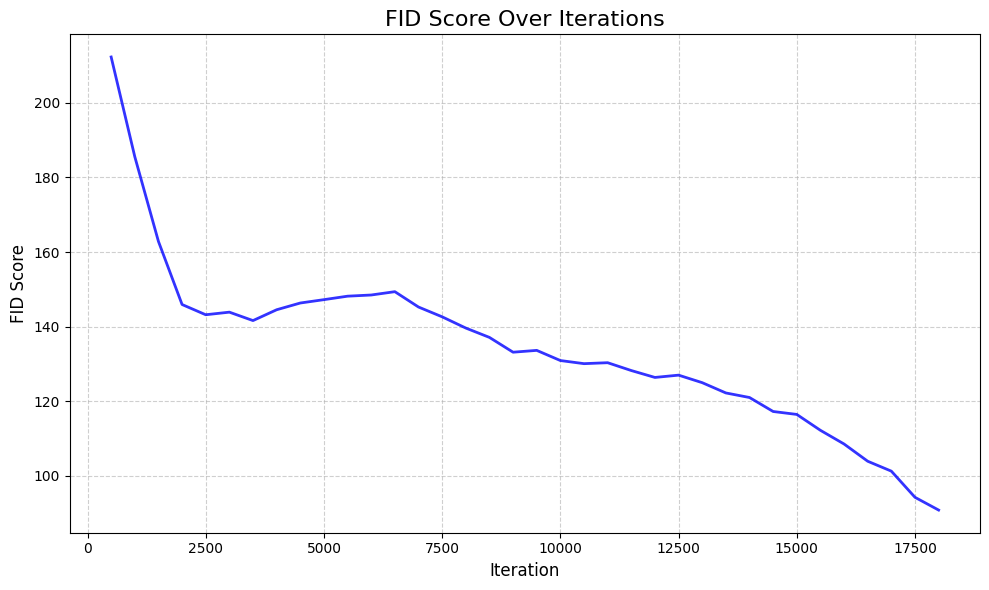

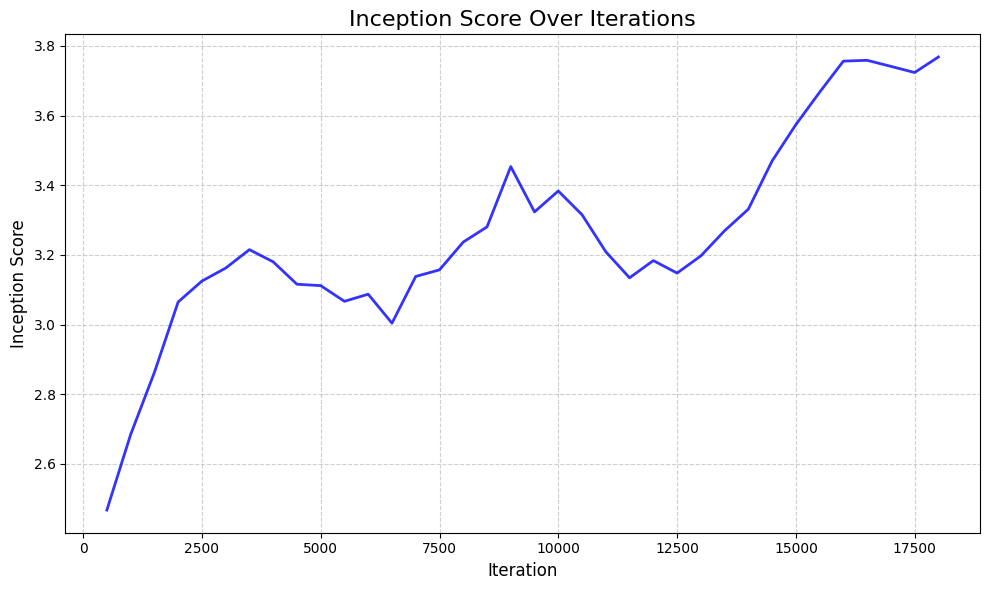

In [13]:
show_graph(ins.get_FID(), "FID Score Over Iterations", "Iteration", "FID Score")
show_graph(ins.get_IS(), "Inception Score Over Iterations", "Iteration", "Inception Score")

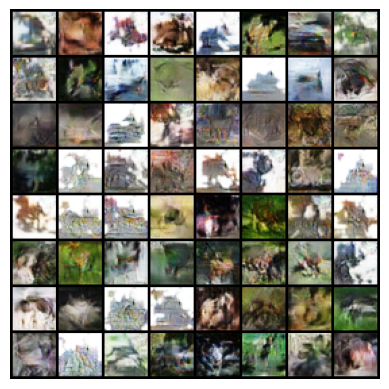

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image from the uploaded file or a specific directory
image_path = '/content/sample/1726334044403/fake_20000.png'  # Replace with the name or path of your uploaded image

# Open and display the image
img = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axes for a cleaner look
plt.show()


# Conclusion

The results already look quite promising. The training has been run over 20000 iterations. As in the graph we can see that FID score is decreasing and Inception score is increasing.This is a good indicator that the model is learning well.

The final FID score and IS score after 20000 iterations are as following.
Inception Score: 3.93455, FID: 81.75984029590899

=======================================================================================================================================================================================================